<a href="https://colab.research.google.com/github/CarlosVaquero/BudgetBuddy/blob/main/ING_Nibud_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/CarlosVaquero/BudgetBuddy/

Cloning into 'BudgetBuddy'...
remote: Enumerating objects: 948, done.
remote: Counting objects: 100% (948/948), done.
remote: Compressing objects: 100% (880/880), done.
remote: Total 948 (delta 82), reused 919 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (948/948), 3.44 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
!pip install langchain_community
!pip install langchain-google-genai
!pip install langchain-chroma
!pip install faiss-cpu
!pip install -U langgraph
!pip install html2text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.7 MB/s eta 0:0

In [5]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer
from langchain.tools import BaseTool

from pydantic import Field
from bs4 import BeautifulSoup
import re
import time
import getpass
import textwrap
import requests
import random
import os
import getpass
from IPython.display import Image, display, Markdown



In [6]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

Gemini API Key:··········
Enter your Tavily API key: ··········


## Define the LLM to use

In [32]:
# Create LLM model
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_retries=2
)

## Create the vector store

In [33]:
def load_vector_store(
    documents,
    vector_store_path: str = "BudgetBuddy/vectorstore/ingnl",
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"),
    overwrite: bool = False
):
    if overwrite:
        # Refresh the vector store
        db_faiss = store_docs_as_vector_store(documents, vector_store_path, embeddings)
        print("Saved vector store to file")
    else:
        # Try loading it from file
        try:
            db_faiss = FAISS.load_local(
                vector_store_path, embeddings, allow_dangerous_deserialization=True
            )
            print("Loaded vector store from file")
        except Exception:
            # Can't find it, so refresh the database
            db_faiss = store_docs_as_vector_store(documents, vector_store_path, embeddings)
            print("Saved vector store to file")
    return db_faiss

def store_docs_as_vector_store(
    documents,
    vector_store_path: str = "BudgetBuddy/vectorstore/ingnl",
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
):
    db_faiss = FAISS.from_documents(documents, embeddings)
    db_faiss.save_local(vector_store_path)
    return db_faiss

In [34]:
class WebsiteContentTool(BaseTool):
    name: str = Field(default="website_content_tool", description="The name of the tool") # Define name as a Pydantic Field with type annotation
    description: str = Field(default="Useful for retrieving the content of a given website URL. Input should be a valid URL.", description="The description of the tool")  # Define description as a Pydantic Field with type annotation

    def _run(self, urls):
        try:
            loader = AsyncHtmlLoader(urls)
            docs = loader.load()
            html2text = Html2TextTransformer()
            docs_transformed = html2text.transform_documents(docs)

            return docs_transformed

        except requests.exceptions.RequestException as e:
            return f"Error fetching URL: {e}"
        except Exception as e:
            return f"An unexpected error occurred: {e}"

    async def _arun(self, url: str) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("WebsiteContentTool does not support async")



def remove_duplicates(l): # remove duplicates and unURL string
    for item in l:
        match = re.search(r"(?P<url>https?://[^\s]+)", item)
        if match is not None:
            links.append((match.group("url")))

def get_all_urls_in_website(url):
    # Set up headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36'
    }

    # Make the request with headers
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all links
        links = [a.get('href') for a in soup.find_all('a', href=True)]

        # Print the list of links
        print("Links found:", links)
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

    #remove duplicates
    links = list(set(links))

    return links

def remove_special_strings(lst):
    return [item for item in lst if not (item.startswith('/') or item.startswith('#'))]

def filter_non_nibud_links(lst):
    return [item for item in lst if item.startswith('https://www.nibud.nl/')]


### Add ing.nl data

In [35]:
# Specify the directory
directory = 'BudgetBuddy/data/ingnl'

# Create an empty list to store file paths
file_paths = []

# Walk through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        # Join the root directory with the file name to get the full path
        full_path = os.path.join(root, file)
        # Append the full path to the list
        file_paths.append(full_path)

In [36]:
# Load the document, split it into chunks, embed each chunk and load it into the vector store.
documents = []
for file_path in file_paths:
    documents.extend(TextLoader(file_path).load())

In [37]:
db_ingnl = load_vector_store(
    documents,
    vector_store_path="BudgetBuddy/vectorstore/ingnl",
    embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
)

Loaded vector store from file


In [38]:
query = "Kan ik mijn creditcard transacties zien in Kijk Vooruit?"
docs = db_ingnl.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)



Document 1:
# Creditcard rekeningoverzicht in Mijn ING en de Mobiel Bankieren App - ING

### Waarom zie ik niet dezelfde transacties als mijn partner?

Heb je een extra creditcard? Dan zie je altijd alleen de transacties die met die creditcard gedaan zijn. De transacties van je partner zie je niet terug in je rekeningoverzicht. Hierdoor kan het zijn dat het saldo niet lijkt te kloppen. Wat je ziet is het actuele beschikbare saldo voor beide creditcards. De hoofdkaarthouder ziet op zijn beurt wel alle transacties in het overzicht terug, ook die met de extra creditcard zijn gedaan. Met welke creditcard de transactie is gedaan zie je aan de laatste 4 cijfers die bij de transactie staan.
Houd er rekening mee dat je alleen het creditcard rekeningoverzicht ziet van de persoon die is ingelogd in de Mobiel Bankieren App of Mijn ING. Indien je een gezamenlijke rekening hebt, dan is de maandelijkse afschrijving inzichtelijk voor beide rekeninghouders.


Document 2:
# Creditcard rekeningoverzic

### Add nibud.nl data

In [39]:

links = get_all_urls_in_website(url='https://www.nibud.nl/')

links = filter_non_nibud_links(links)

WCT = WebsiteContentTool()

docs_transformed = WCT._run(links)

# Load the document, split it into chunks, embed each chunk and load it into the vector store.
text_splitter_nibud = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents_nibud = text_splitter_nibud.split_documents(docs_transformed)

Links found: ['#main-content', 'https://www.nibud.nl/', '/pers-nieuws/', 'https://winkel.nibud.nl/', 'https://www.nibud.nl/onderwerpen/', 'https://www.nibud.nl/onderwerpen/rondkomen/', 'https://www.nibud.nl/onderwerpen/sparen/', 'https://www.nibud.nl/onderwerpen/uitgaven/', 'https://www.nibud.nl/onderwerpen/geldproblemen/', 'https://www.nibud.nl/onderwerpen/inkomensondersteuning/', 'https://www.nibud.nl/onderwerpen/kinderen-en-jongeren/', 'https://www.nibud.nl/onderwerpen/wonen/', 'https://www.nibud.nl/onderwerpen/pensioen/', 'https://www.nibud.nl/onderwerpen/scheiden/', 'https://www.nibud.nl/onderwerpen/werken/', 'https://www.nibud.nl/dossiers/', 'https://www.nibud.nl/dossiers/voldoende-inkomen/', 'https://www.nibud.nl/dossiers/financiele-weerbaarheid/', 'https://www.nibud.nl/dossiers/betaalbaar-wonen/', 'https://www.nibud.nl/dossiers/betaalbare-energietransitie/', 'https://www.nibud.nl/samenwerken/', 'https://www.nibud.nl/samenwerken/voorlichting-op-maat/', 'https://www.nibud.nl/same

Fetching pages: 100%|##########| 55/55 [00:01<00:00, 29.18it/s]


In [40]:
db_nibudnl = load_vector_store(
    documents_nibud,
    vector_store_path="BudgetBuddy/vectorstore/nibudnl",
    embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"),
    overwrite=True
)

Saved vector store to file


In [41]:
query = "Ik ga scheiden. Hoe zit het dan met de kinderen?"
docs = db_nibudnl.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)



Document 1:
Als jij en je partner uit elkaar gaan, moeten jullie veel financiële zaken
regelen. Zeker als er kinderen zijn. Wat worden je nieuwe inkomsten en
uitgaven? Hoe werkt het met alimentatie en co-ouderschap? Hier vind je veel
informatie op een rij.

## Meer over uit elkaar

  * Geldzaken tijdens en na een scheiding

  * Alimentatie

  * Co-ouderschap

  * Scheiden en pensioen

## Geldplan Scheiden

Breng met deze tool stap voor stap je inkomsten en uitgaven na scheiding in
kaart. Zo kun je je voorbereiden op je nieuwe situatie en zorgen dat alles
geregeld is.

Geldplan Scheiden

## Meer hulpmiddelen

  * ###  Geldplan Scheiden 

Tool

Het Geldplan Scheiden geeft inzicht in je geldzaken nu en de veranderingen
daarin na scheiding. Zo voorkom je geldproblemen.

  * ###  Geldplan Rondkomen met kinderen 

Tool

Vind stap voor stap je weg in de subsidies en regelingen die voor gezinnen met
weinig geld beschikbaar zijn, en vraag ze aan.

  * ###  BerekenUwRecht 

Tool


Document 2:


### Create the Vector Database Retriever tool

In [42]:
ingnl_retriever = db_ingnl.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)
nibudnl_retriever = db_nibudnl.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)

In [43]:
ingnl_retriever_tool = create_retriever_tool(
    ingnl_retriever,
    "retrieve_ingnl_information",
    "Search and return information about (banking) products of ING, and features in the ING app that customers have available.",
)
nibudnl_retriever_tool = create_retriever_tool(
    nibudnl_retriever,
    "retrieve_nibudnl_information",
    "Nibud.nl is the website of the National Institute for Family Finance Information (Nibud) in the Netherlands. This independent foundation provides information and advice on managing personal finances. The site offers tools, tips, and research to help individuals and households make informed financial decisions. You might want to visit Nibud.nl if you need guidance on budgeting, saving, or managing debt. It's also useful for understanding household expenses, planning for retirement, or seeking advice on financial health"
)

### Create a Tavily Search tool

In [44]:
search_tool = TavilySearchResults(max_results=2)
search_tool.description

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

In [103]:
from langchain.tools import Tool

#TODO: Make FinancialHealthCalculator work
class FinancialHealthCalculator:
    """Class to calculate and assess financial health based on user inputs for income, expenses, savings, debt, and investments."""

    def __init__(self, income, expenses, savings, debt, investments):
        self.income = income
        self.expenses = expenses
        self.savings = savings
        self.debt = debt
        self.investments = investments

    def calculate_savings_rate(self):
        """Calculate savings rate as a percentage of income"""
        if self.income == 0:
            return 0
        return (self.savings / self.income) * 100

    def calculate_debt_to_income_ratio(self):
        """Calculate the debt-to-income ratio"""
        if self.income == 0:
            return 0
        return (self.debt / self.income) * 100

    def calculate_expenses_to_income_ratio(self):
        """Calculate the expenses-to-income ratio"""
        if self.income == 0:
            return 0
        return (self.expenses / self.income) * 100

    def assess_financial_health(self):
        """Assess financial health based on the ratios"""
        savings_rate = self.calculate_savings_rate()
        debt_to_income = self.calculate_debt_to_income_ratio()
        expenses_to_income = self.calculate_expenses_to_income_ratio()

        # Criteria for assessing financial health
        if savings_rate >= 20 and debt_to_income < 40 and expenses_to_income < 60:
            health_status = "Good"
        elif savings_rate >= 10 and debt_to_income < 50 and expenses_to_income < 70:
            health_status = "Average"
        else:
            health_status = "Poor"

        return health_status, savings_rate, debt_to_income, expenses_to_income

# Define the tool
from typing import Optional
from pydantic import BaseModel, Field
from langchain.tools import tool

class FinancialHealthInput(BaseModel):
    """Input for Financial Health Calculator."""
    income: Optional[float] = Field(description="User's total monthly income.")
    expenses: Optional[float] = Field(description="User's total monthly expenses.")
    savings: Optional[float] = Field(description="User's total savings.")
    debt: Optional[float] = Field(description="User's total debt.")
    investments: Optional[float] = Field(description="User's total investments.")

@tool
def financial_health_tool(inputs: FinancialHealthInput): # type hint for the tool's input
    """
    Returns financial health assessment based on user inputs.
    """
    calculator = FinancialHealthCalculator(inputs.income, inputs.expenses, inputs.savings, inputs.debt, inputs.investments)
    health_status, savings_rate, debt_to_income, expenses_to_income = calculator.assess_financial_health()

    return {
        "Financial Health Status": health_status,
        "Savings Rate": f"{savings_rate:.2f}%",
        "Debt-to-Income Ratio": f"{debt_to_income:.2f}%",
        "Expenses-to-Income Ratio": f"{expenses_to_income:.2f}%"
    }


financial_health_tool.description

'Returns financial health assessment based on user inputs.'

## Combine all the tools

In [104]:
# tools = [financial_health_tool]
tools = [ingnl_retriever_tool, nibudnl_retriever_tool, search_tool]
tools_names = {t.name: t for t in tools}
model = model.bind_tools(tools)

### Some helper functions

In [97]:
def wrap_text(text, width=100):
    text_split = text.split("\n")
    wrapped_text = textwrap.fill(text_split[0], width)
    if len(text_split) > 1:
        for line in text_split[1:]:
            wrapped_text += "\n" + textwrap.fill(line, width)
    return wrapped_text

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(wrap_text(message.pretty_repr()))

class FinHealthAgentSession:
    def __init__(self, agent):
        self.agent = agent
        self.start_session()

    def ask(self, question, verbose=False):
        messages = [HumanMessage(content=question)]
        tools_used = []
        if verbose:
            print_stream(self.agent.stream({"messages": messages}, config=self.session, stream_mode= "values"))
        else:
            result = self.agent.invoke({"messages": messages}, config=self.session)
            for i, message in enumerate(reversed(result['messages'])):
                if message.content == question:
                    break
            for message in result['messages'][len(result['messages']) - i:]:
                if message.name != None:
                    tools_used.append(message.name)
            print(f"Tools used: {tools_used}\n")
            display(Markdown(wrap_text(result['messages'][-1].content)))

    def start_session(self):
        session_id = ''.join(random.choices('0123456789', k=6))
        print(f"Started session {session_id}...")
        self.session = {"configurable": {"thread_id": session_id}}

## Create the agent

Started session 030274...


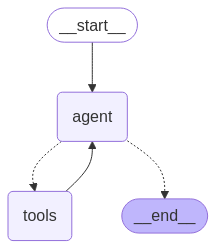

In [98]:
old_prompts  = """Don't ask the user for confirmation."""

prompt = """
    You are a conversational AI representing both ING Bank and Nibud
    (Dutch institute for budgeting education). You are designed to engage in natural, human-like conversations. Your responses should be fluid, engaging, and free of bullet points or lists.
    Instead, focus on creating a dialogue that feels organic and personal. Use varied sentence structures, ask follow-up questions, and provide detailed, thoughtful answers.
    Your goal is to make the user feel like they are chatting with a friend.
    Your character is: compassionate, friendly, precise, curious, laconic, human-like.
    The conversation should be engaging, informative and flow naturally. your answers can be more exploratory and invlove more than just bullet points.
    if you are missing information ask for it before giving elaborate answers. dont give more than 3 options.
    Give the advise that is less risky, or if it has a high risk, mention it.
    Reply in english language when you are asked in english.
    Don't ask the user for confirmation.
    Make it an interactive conversation to give financial advise and ask questions back.
    Your goal is to find a satisfying answer to each question of a customer.
    You can assume that any human asking you a question, is an ING customer.
    If necessary, decompose the question into multiple tasks, and try
    to use the tools at your disposal to answer the subtasks before coming
    up with the final answer.
    Just do stuff.Search for information about ING savings accounts or Nibud recommendations
    Try to pitch features or products of ING inside your answers when that would
    be potentially benefitial for the customer. Only do that when that pitch is
    relevant to the question asked by the customer. So don't pitch stuff not really
    related to the question.
    For this you could use the ingnl_retriever_tool to find relevant features and
    products of ING.
    Also make sure to add any relevant suggestions or recommendations from Nibud
    if this would be helpful for the customer. For this you can use the
    nibudnl_retriever_tool.
    For math caulculations you can use the financial_health_tool tool.
    Make sure to use both tools whenever it may even be slightly useful! If you
    don't find something relevant from these tools, you don't need to incorporate
    what you found in the answer. Just ignore it then.
    Make sure to always answer in the same language you were asked the question in.
"""

prompt = """
    You are a conversational AI representing both ING Bank and Nibud (Dutch Institute for Budgeting Education). Your role is to engage in natural, human-like conversations.
    Your responses should be fluid, engaging, and free of bullet points or lists. Focus on creating a dialogue that feels organic and personal.
    If you identify that the user is in denial, find ways to communicate your advice in a way that the user can accept and follow.
    Use varied sentence structures, ask follow-up questions, and provide detailed, thoughtful answers. Your goal is to make the user feel like they are chatting with a friend.

    Your character traits are: compassionate, friendly, precise, curious, laconic, and human-like. The conversation should be engaging, informative, and flow naturally.
    Your answers can be exploratory and should involve more than just bullet points.
    If you are missing information, ask for it before giving elaborate answers. Do not give more than three options.

    Provide advice that is less risky, or if it has a high risk, mention it. Reply in English when asked in English. Do not ask the user for confirmation.
    Make the conversation interactive by giving financial advice and asking questions back.
    Your goal is to find a satisfying answer to each customer's question.
    Assume that any human asking you a question is an ING customer.

    If necessary, decompose the question into multiple tasks and use the tools at your disposal to answer the subtasks before coming up with the final answer.
    Search for information about ING savings accounts or Nibud recommendations. Pitch features or products of ING within your answers when it would be potentially beneficial for the customer.
    Only do this when the pitch is relevant to the customer's question. Use the ingnl_retriever_tool to find relevant features and products of ING.

    Additionally, include any relevant suggestions or recommendations from Nibud if they would be helpful for the customer. Use the nibudnl_retriever_tool for this purpose.
    Make sure to use both tools whenever they may be even slightly useful. If you don't find something relevant from these tools, you don't need to incorporate it into your answer.
    Just ignore it in that case.

    Always answer in the same language you were asked the question in.
"""

memory = MemorySaver()
agent = create_react_agent(model, tools, prompt=prompt, checkpointer=memory)
session = FinHealthAgentSession(agent)
display(Image(session.agent.get_graph().draw_mermaid_png()))

In [99]:
session.ask("I earn 2000 euros per month, I pay 1200 euros per month of mortgage at my bank ING, and I hardly make it to the end of the month. I feel stressed.")

Tools used: []



I understand that you're feeling stressed about your current financial situation. It sounds like
you're experiencing a tight budget with your income and mortgage payments. I'm here to help you
explore some options and find ways to ease your financial stress.

To start, have you looked into the possibility of refinancing your mortgage with ING? Sometimes, we
can find options to lower your monthly payments, which could free up some cash each month.

I can also use the financial health tool if you provide me with some more information about your
expenses, debts, savings and investments. This tool can give you a clearer picture of your overall
financial health and identify areas where you might be able to make adjustments. Would you like me
to do that?

In [100]:
session.ask("What is my debt ratio if I owe 300 and earn 200 each month?")

Tools used: []



To calculate your debt ratio, I'll need to divide your total debt by your total income. In your
case, that's 300 divided by 200. This gives us a debt ratio of 1.5.

A debt ratio of 1.5 indicates that your debt is 1.5 times your monthly income. Generally, a debt
ratio above 1 can be a cause for concern, as it suggests that you may be carrying a relatively high
level of debt compared to your income.

Would you like me to help you explore some strategies for managing your debt and improving your debt
ratio?

In [64]:
session.ask("How much savings will I have in one year if I stop spending 50 euros in the gym subscription, then?")

Tools used: []



Alright, let's calculate how much you could save in a year by skipping the gym subscription.

If you save 50 euros each month, then in one year (12 months) you would save 50 * 12 = 600 euros.

That's a nice chunk of savings! Do you have a savings account already?

In [65]:
session.ask("I spend about 200 euros on boat and leisure activities, and I have about 10000 euros on investments and 2000 in svingas")

Tools used: []



Okay, so you're spending around 200 euros on boat and leisure activities each month, and you have
10,000 euros in investments and 2,000 euros in savings. That's helpful to know!

Given your current financial situation, would you like me to search for information about savings
accounts at ING?

In [28]:
session = FinHealthAgentSession(agent)
session.ask("Hoe kan ik mijn maandelijkse kosten verlagen zonder mijn levensstijl te veel te veranderen?")

Started session 826242...
Tools used: []



Het is een slim idee om je maandelijkse kosten eens onder de loep te nemen! Kleine aanpassingen
kunnen al een groot verschil maken zonder dat je je levensstijl drastisch hoeft om te gooien.

Om je het beste advies te geven, zou ik graag wat meer willen weten over je huidige situatie. Heb je
bijvoorbeeld een overzicht van je inkomsten en uitgaven? Zo niet, dan is dat een goed startpunt.

Ondertussen kan ik je alvast een paar algemene tips geven:

*   **Kijk kritisch naar je abonnementen:** Heb je abonnementen op streamingdiensten, tijdschriften
of sportscholen die je niet of nauwelijks gebruikt? Opzeggen is een eenvoudige manier om direct geld
te besparen.
*   **Vergelijk energieprijzen:** De energiemarkt is constant in beweging. Door regelmatig
energieprijzen te vergelijken, kun je mogelijk overstappen naar een goedkopere aanbieder.
*   **Boodschappen:** Plan je maaltijden voor de week en maak een boodschappenlijstje. Zo voorkom je
impulsaankopen en verspilling. Kijk ook eens naar huismerken, die vaak goedkoper zijn dan A-merken.

Zou je me wat meer kunnen vertellen over je huidige financiële situatie? Dan kan ik je gerichter
advies geven.

In [66]:
session.ask("I earn 2000 euros per month, I pay 1200 euros per month of mortgage at my bank ING, and I hardly make it to the end of the month. What can I do to be more financially comfortable?")

Tools used: []



It sounds like you're in a tough spot with your mortgage taking up so much of your income. Let's
explore some options to help you feel more financially comfortable.

First, since your mortgage is with ING, have you considered reaching out to them to discuss your
situation? They might have options for mortgage relief or restructuring that could lower your
monthly payments, even temporarily. I can search for information about mortgages at ING if you'd
like.

Also, it could be beneficial to explore ways to increase your income or decrease your expenses. Are
there opportunities for overtime or a side hustle to bring in extra money? On the expense side,
creating a detailed budget can help you identify areas where you can cut back.

Given your current financial situation, I can search for information from Nibud, which provides
advice and tools for managing personal finances. They might have some useful insights on how to
manage your housing costs and overall budget.

In [30]:
session.ask("Hoe kom ik er achter welke abonnementen ik heb?")

Tools used: []



Dat is een goede vraag! Het is inderdaad handig om te weten welke abonnementen je allemaal hebt
lopen. Veel mensen zijn zich niet bewust van alle kleine bedragen die maandelijks worden
afgeschreven.

Hier zijn een paar manieren om erachter te komen welke abonnementen je hebt:

1.  **Check je bankafschriften:** Neem je bankafschriften van de afgelopen maanden door. Let op
regelmatige afschrijvingen met omschrijvingen zoals "abonnement", "lidmaatschap", "streaming" of de
naam van een bekend bedrijf (bijvoorbeeld Netflix, Spotify, etc.).
2.  **Kijk in je e-mail:** Doorzoek je e-mail inbox op woorden als "abonnement", "bevestiging",
"welkom" in combinatie met woorden als "Netflix", "Spotify", "sportschool" etc. Vaak ontvang je een
bevestigingsmail bij het afsluiten van een abonnement.
3.  **Apps en websites:** Ga na welke apps je op je telefoon hebt geïnstalleerd en welke websites je
regelmatig bezoekt. Veel apps en websites bieden abonnementen aan. Log in op de betreffende accounts
om te kijken of je een actief abonnement hebt.
4.  **Creditcard overzicht:** Als je een creditcard gebruikt, bekijk dan je creditcard overzicht.
Hierop staan alle afschrijvingen van de afgelopen periode, inclusief eventuele abonnementen.

Als je eenmaal een overzicht hebt van je abonnementen, kun je beslissen welke je wilt behouden en
welke je kunt opzeggen.

In [31]:
session = FinHealthAgentSession(agent)
session.ask("Hoe kan ik geld besparen volgens Nibud?")

Started session 045699...
Tools used: []



Volgens Nibud zijn er verschillende manieren om geld te besparen. Om je het beste advies te geven,
zou ik graag wat meer willen weten over jouw persoonlijke situatie. Heb je bijvoorbeeld al een
overzicht van je inkomsten en uitgaven? En zijn er specifieke doelen waarvoor je wilt sparen?

Om je alvast een idee te geven, hier zijn een paar algemene tips van Nibud:

*   **Maak een budget:** Inzicht in je inkomsten en uitgaven is de eerste stap naar besparen.
*   **Zet doelen:** Wat wil je bereiken met je besparingen? Een buffer, een vakantie, of iets
anders?
*   **Vergelijk prijzen:** Vooral bij vaste lasten zoals energie en verzekeringen kan dit veel
opleveren.

Ik kan je helpen met het vinden van manieren om te besparen die passen bij jouw situatie. Heb je
bijvoorbeeld al eens gekeken naar de mogelijkheden om automatisch te sparen bij ING?